# Hack@UCF 100% Organic NCCDC Scoring Engine 
This is a scoring engine for CCDC scrimmage and competition environments. Originally the basis of this program was written in python, but I had a few issues that were solved by Jupyter

1. Graphics. Jupyter + Numpy or other libraries makes visualization a breeze as compared to before
2. The ability to chain scripts. Part of the scoring engine requires the user to set some variables dependent on their environment. Given that Icinga doesn't flush it's databases each time you have an event, we can use this notebook to easily compile the information required per event


In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import pymysql.cursors
import configparser
from IPython.core.display import display, HTML
import matplotlib.pyplot as plt
import pandas as pd
import time, datetime

## Step 1: Environment Configuration
Given that your environment is already setup within Icinga2, we must gather certain identifiers which Icinga uses internally in order to get the correct information from the tooling.

In this next step, we will define a few parameters pertaining to Icinga2's setup. Primarily pertaining to databases.

In [3]:
# Load in the credentials from the ini file
credentials = configparser.ConfigParser()
credentials.read('credentials.ini')

# Connect to the mysql server running on the icinga2 server
connection = pymysql.connect(host=credentials['database']['host'], 
                             user=credentials['database']['username'], 
                             password=credentials['database']['password'], 
                             db=credentials['database']['db'], 
                             cursorclass=pymysql.cursors.DictCursor)

cursor = connection.cursor()

## Step 2: Environment Enumeration and Host Selection
Now that we are able to connect to Icinga's internal database, we must select which hosts to generate scores for. Icinga doesn't flush the database holding all hosts per each event, so each time a new competition is held, the hosts selected will change. In order to ensure that the correct hosts are watched, we will compile a list of hostIDs.

In [4]:
query = "select host_object_id, display_name, address from icinga_hosts;"

cursor.execute(query)

results = cursor.fetchall()

df = pd.DataFrame.from_dict(results)

df.style.set_properties(**{'text-align': 'left'})

,address,display_name,host_object_id
0,127.0.0.1,icinga,219
1,192.168.50.104,AMediawiki,247
2,192.168.50.104,A Mediawiki,249
3,192.168.50.101,A Linux Wordpress,251
4,192.168.50.104,A Windows MediaWiki,252
5,192.168.50.102,A Linux Bind,253
6,192.168.50.106,A Windows Mail,254
7,192.168.50.105,A Windows AD/DNS,255
8,192.168.50.103,A Linux DB,256
9,192.168.50.102,A - Linux - Bind,263


Once you know what object IDs the hosts you are scoring will use, enter them into the following list:

In [5]:
scored_hosts = [332,331,330,329,328,327,326,325,324,323]

## Service Verification
This step will now complete a query on the selected hosts to see what services will be checked for each host. Please ensure that this is correct before moving on to the next step.

In [9]:
for host in scored_hosts:
    query = "select service_id, display_name from icinga_services where host_object_id = %s;" % host
    
    cursor.execute(query)
    
    services = cursor.fetchall()
    
    query = "select display_name from icinga_hosts where host_object_id = %d" % host
    
    cursor.execute(query)
    
    hostname = cursor.fetchone()['display_name']
    
    display(HTML("<b>Host: [%s] %s</b>" % (host,hostname)))
    display(pd.DataFrame.from_dict(services))
    display(HTML("<hr size=\"30\">"))

,display_name,service_id
0,http,65
1,ping4,79
2,smtp,94


,display_name,service_id
0,dns,67
1,mysql,76
2,ping4,92


,display_name,service_id
0,http,77
1,ssh,83
2,ping4,89


,display_name,service_id
0,ping4,70
1,http,73
2,mysql,74


,display_name,service_id
0,mysql,66
1,http,82
2,ping4,86


,display_name,service_id
0,ping4,85
1,http,88
2,smtp,93


,display_name,service_id
0,dns,75
1,ping4,81
2,mysql,90


,display_name,service_id
0,ping4,72
1,smb,78
2,ftp,87


,display_name,service_id
0,http,68
1,ping4,69
2,ssh,80


,display_name,service_id
0,smb,71
1,ftp,84
2,ping4,91


## Step 3. Time Configuration
At this point, we must now determine what time range is to be scored. The values entered into the next section will determine the time range to be scored:

In [10]:
time.strftime('%Y-%m-%d %H:%M:%S')

#datetime.datetime(year, month, day, hour, minute, {second}), Omittable starting from right (seconds usually omitted)
start_datetime = datetime.datetime(2018, 11, 9, 0, 0)
end_datetime = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")

## Step 4. SCORING! YAY!
Now we get to actual scoring. Each service's uptime will be calculated during the selected time range. Each service's uptime will be shown. Under each host will be it's individual uptime percentage.

,name,uptime
0,http,0.8813
1,ping4,80.6193
2,smtp,80.2032
3,Average,53.9013


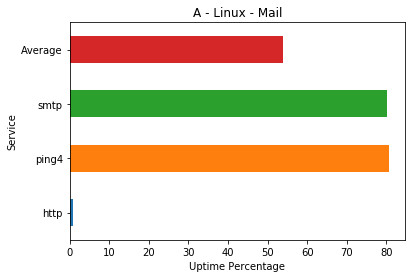

,name,uptime
0,dns,NaN
1,mysql,NaN
2,ping4,NaN
3,Average,0.0


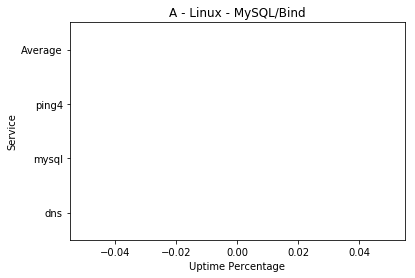

,name,uptime
0,http,NaN
1,ssh,NaN
2,ping4,NaN
3,Average,0.0


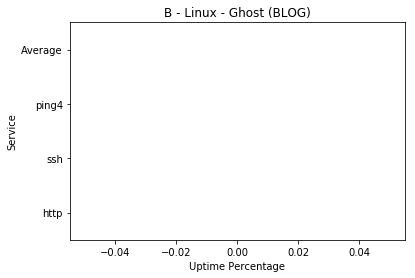

,name,uptime
0,ping4,80.6332
1,http,80.6759
2,mysql,None
3,Average,53.7697


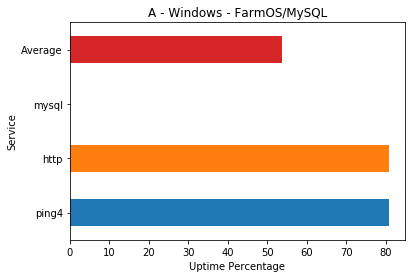

,name,uptime
0,mysql,NaN
1,http,NaN
2,ping4,NaN
3,Average,0.0


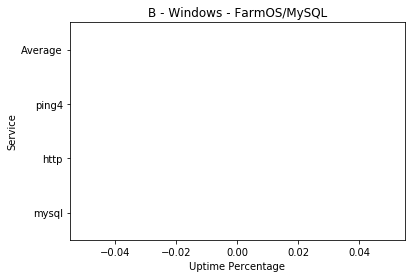

,name,uptime
0,ping4,80.6642
1,http,None
2,smtp,None
3,Average,26.8881


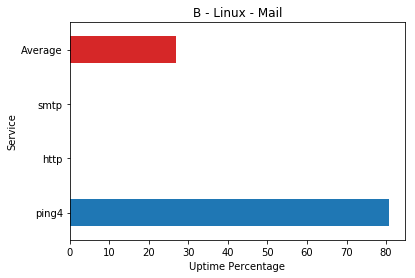

,name,uptime
0,dns,NaN
1,ping4,NaN
2,mysql,NaN
3,Average,0.0


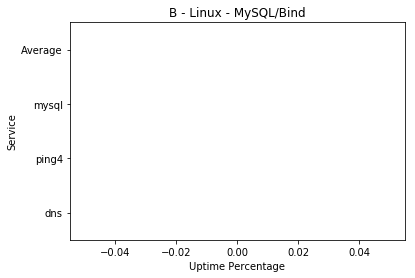

,name,uptime
0,ping4,NaN
1,smb,NaN
2,ftp,NaN
3,Average,0.0


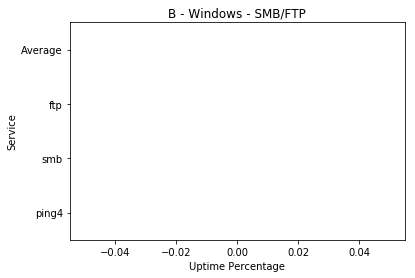

,name,uptime
0,http,NaN
1,ping4,NaN
2,ssh,NaN
3,Average,0.0


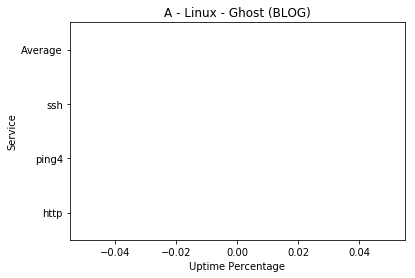

,name,uptime
0,smb,None
1,ftp,80.6513
2,ping4,80.6642
3,Average,53.7718


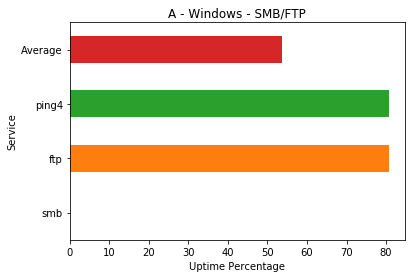

In [11]:
for host in scored_hosts:
    query = "select service_object_id, display_name from icinga_services where host_object_id = %s;" % host
    
    cursor.execute(query)
    
    services = cursor.fetchall()
    
    query = "select display_name from icinga_hosts where host_object_id = %d" % host
    
    cursor.execute(query)
    
    hostname = cursor.fetchone()['display_name']
    
    display(HTML("<b>Host: [%s] %s</b>" % (host,hostname)))
    
    uptimes = []
    uptime_sum = 0.0;
    for service in services:
        query = "select icinga2.icinga_availability(%s,\"%s\",\"%s\") as uptime;" % (service['service_object_id'],start_datetime,end_datetime)

        cursor.execute(query)
        
        uptime = cursor.fetchone()['uptime']
        
        if(uptime != None):
            uptime_sum = uptime_sum + float(uptime)
        
        uptimes.append({"name":service['display_name'], "uptime": uptime})
    
    ## Summation of data and plotting
    average_uptime = uptime_sum/len(uptimes)
    uptimes.append({'name':'Average','uptime':average_uptime}) #Adds the average value to the data
    uptime_data = pd.DataFrame.from_dict(uptimes)
    display(uptime_data)

    ## Create the fancy plot
    uptime_data.uptime = uptime_data.uptime.astype(float)
    uptime_plot = uptime_data.plot(title=hostname, kind="barh",x='name',y='uptime', legend=False)
    uptime_plot.set_xlabel("Uptime Percentage")
    uptime_plot.set_ylabel("Service")
    plt.show()
    
    ## Print out average and rule at end
    display(HTML("<i>Average Uptime: %s</i>" % (average_uptime)))
    display(HTML("<hr size=\"20\">"))
        